In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import numpy as np
import os
from scipy import linalg
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.transforms import Resize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = img_shape[1] // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.validity_layer = nn.Linear(512, 1)
        self.label_layer = nn.Linear(512, num_classes)

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        d_out = self.model(d_in)
        validity = self.validity_layer(d_out)
        label = self.label_layer(d_out)

        return validity, label
        
def calculate_fid(model, real_imgs, gen_imgs, batch_size=100):
    model.eval()
    resize = Resize((299, 299), antialias=True)

    real_features = []
    gen_features = []

    with torch.no_grad():
        for i in range(0, len(real_imgs), batch_size):
            real_batch = real_imgs[i:i+batch_size]
            gen_batch = gen_imgs[i:i+batch_size]

            # Resize images
            real_batch_resized = resize(real_batch).to(device)
            gen_batch_resized = resize(gen_batch).to(device)

            # Get features
            real_batch_features = model(real_batch_resized).detach().cpu().numpy()
            gen_batch_features = model(gen_batch_resized).detach().cpu().numpy()

            real_features.append(real_batch_features)
            gen_features.append(gen_batch_features)

    # Concatenate all features
    real_features = np.concatenate(real_features, axis=0)
    gen_features = np.concatenate(gen_features, axis=0)

    # Calculate mean and covariance
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    
    # Calculate FID
    ssdiff = np.sum((mu_real - mu_gen) ** 2)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(real_pred, fake_pred, labels, gen_labels):
    # Compute accuracy for real images
    _, predicted_labels_real = torch.max(real_pred, 1)
    acc_real = torch.mean((predicted_labels_real == labels).float()).item()

    # Compute accuracy for fake images
    _, predicted_labels_fake = torch.max(fake_pred, 1)
    acc_fake = torch.mean((predicted_labels_fake == gen_labels).float()).item()

    return acc_real, acc_fake

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

def plot_metrics(metrics, epochs):
    # Plotting Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['acc_real'], label='Accuracy Real')
    plt.plot(epochs, metrics['acc_fake'], label='Accuracy Fake')
    plt.title('Discriminator Accuracy During Training')
    plt.xlabel('Eval')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['d_loss'], label='Discriminator Loss')
    plt.plot(epochs, metrics['g_loss'], label='Generator Loss')
    plt.title('Discriminator and Generator Loss During Training')
    plt.xlabel('Eval')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting FID, sFID, Class-aware-FID, and MiFID
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['fid'], label='FID')
    plt.title('FID During Training')
    plt.xlabel('Eval')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [35]:
transform = transforms.Compose([
    # transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [36]:
# Hyperparameters
num_epochs = 300
latent_dim = 128  # Size of the latent space (noise vector)
num_classes = 10  # CIFAR-10 has 10 classes
batch_size = 128
img_shape = (3, 32, 32)  # Adjust if you used a different image size

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
auxiliary_loss = nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator(latent_dim, num_classes, img_shape).apply(weights_init_normal).cuda()
discriminator = Discriminator(num_classes, img_shape).apply(weights_init_normal).cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
aux_criterion = nn.CrossEntropyLoss()

metrics = {'acc_real': [], 'acc_fake': [], 'd_loss': [], 'g_loss': [], 'fid': []}

# Training Loop
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        batch_size = imgs.shape[0]
        valid = torch.ones(batch_size, 1).cuda()
        fake = torch.zeros(batch_size, 1).cuda()

        # Configure input
        real_imgs = imgs.cuda()
        labels = labels.cuda()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(batch_size, latent_dim).cuda()
        gen_labels = torch.randint(0, num_classes, (batch_size,)).cuda()
        
        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs, labels)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
        
        # Save Images every batch (or less frequently)
        batches_done = epoch * len(train_loader) + i
        if batches_done % 5000 == 0:
            save_image(gen_imgs.data[:25], f"{batches_done}.png", nrow=5, normalize=True)

        if batches_done % 500 == 0:
            # Generate a batch of images
            z = torch.randn(100, latent_dim).cuda()
            gen_imgs = generator(z, gen_labels[:100]).detach()
            
            fid_value = calculate_fid(inception_model, real_imgs[:100], gen_imgs)
            print(f'FID at batch {batches_done}: {fid_value}')

    if (epoch+1)%5 == 0:
        metrics['fid'].append(fid_value)
        metrics['d_loss'].append(d_loss)
        metrics['g_loss'].append(g_loss)
        acc_real, acc_fake = summarize_performance(real_pred, fake_pred, labels, gen_labels)
        metrics['acc_real'].append(acc_real)
        metrics['acc_fake'].append(acc_fake)
        print(metrics['d_loss'],metrics['g_loss'])

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


[Epoch 0/5] [Batch 0/391] [D loss: 1.4979002475738525] [G loss: 3.0189218521118164]
FID at batch 0: -4.0289432243439114e+41
[Epoch 0/5] [Batch 1/391] [D loss: 1.4902229309082031] [G loss: 3.0133156776428223]
[Epoch 0/5] [Batch 2/391] [D loss: 1.480097770690918] [G loss: 3.007755756378174]
[Epoch 0/5] [Batch 3/391] [D loss: 1.4633886814117432] [G loss: 2.998659133911133]
[Epoch 0/5] [Batch 4/391] [D loss: 1.4522532224655151] [G loss: 2.9811911582946777]
[Epoch 0/5] [Batch 5/391] [D loss: 1.4390231370925903] [G loss: 2.9546868801116943]
[Epoch 0/5] [Batch 6/391] [D loss: 1.4296815395355225] [G loss: 2.9194183349609375]
[Epoch 0/5] [Batch 7/391] [D loss: 1.4259490966796875] [G loss: 2.8972456455230713]
[Epoch 0/5] [Batch 8/391] [D loss: 1.396221399307251] [G loss: 2.880749464035034]
[Epoch 0/5] [Batch 9/391] [D loss: 1.400420904159546] [G loss: 2.8791821002960205]
[Epoch 0/5] [Batch 10/391] [D loss: 1.3718016147613525] [G loss: 2.9121780395507812]
[Epoch 0/5] [Batch 11/391] [D loss: 1.358

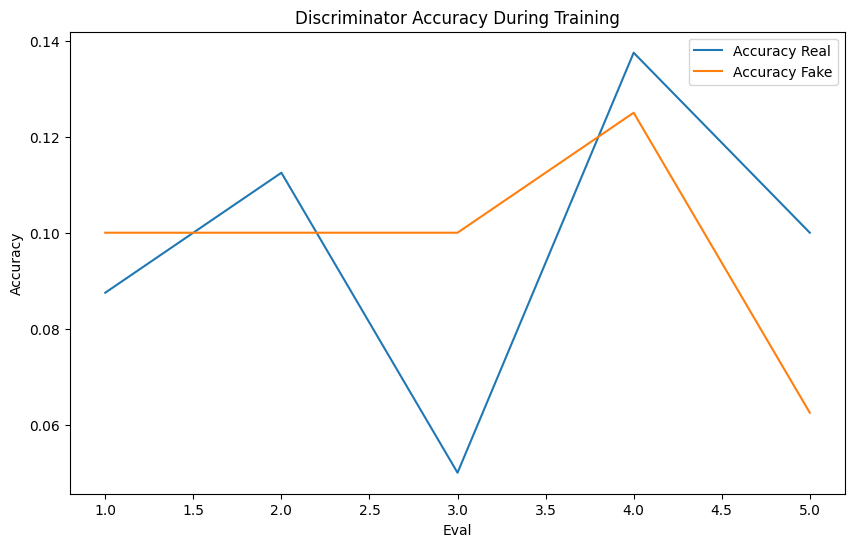

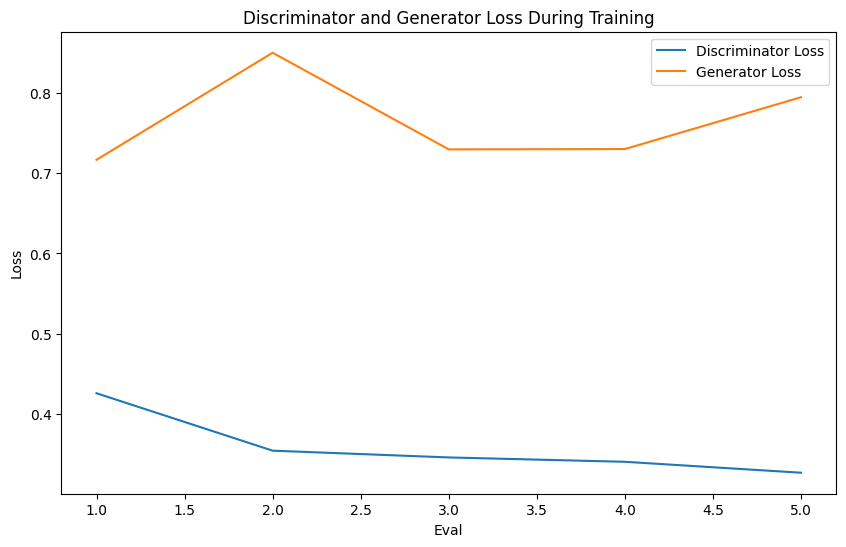

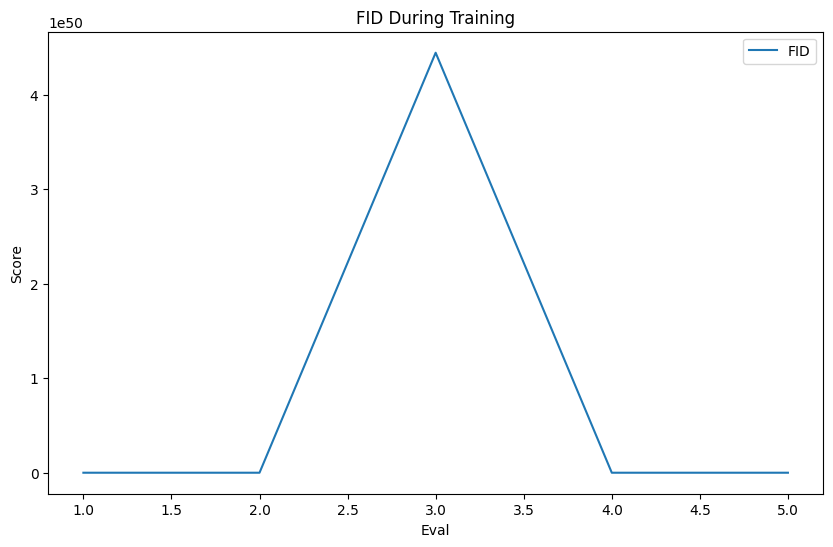

In [44]:
metrics['d_loss'] = [tensor.cpu().detach().numpy() for tensor in metrics['d_loss']]
metrics['g_loss'] = [tensor.cpu().detach().numpy() for tensor in metrics['g_loss']]
epochs = range(1, len(metrics['d_loss']) + 1)
plot_metrics(metrics, epochs)

In [38]:
# Hyperparameters
num_epochs = 300
latent_dim = 128  # Size of the latent space (noise vector)
num_classes = 10  # CIFAR-10 has 10 classes
batch_size = 128
img_shape = (3, 32, 32)  # Adjust if you used a different image size

generator = Generator(latent_dim, num_classes, img_shape).cuda()
discriminator = Discriminator(num_classes, img_shape).cuda()

generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

generator.eval()
discriminator.eval()

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=3082, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (validity_layer): Linear(in_features=512, out_features=1, bias=True)
  (label_layer): Linear(in_features=512, out_features=10, bias=True)
)

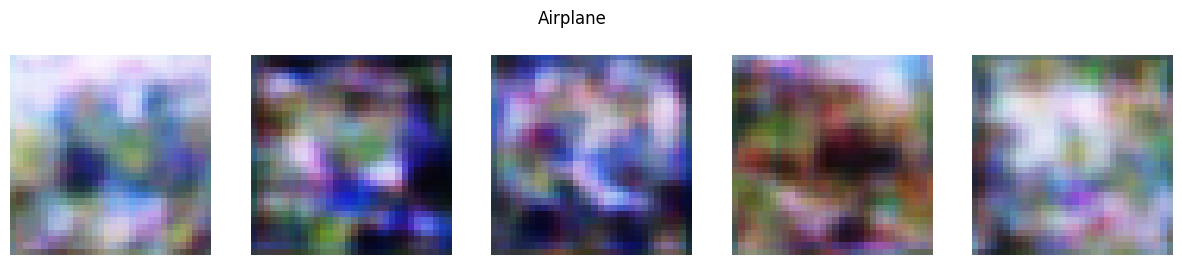

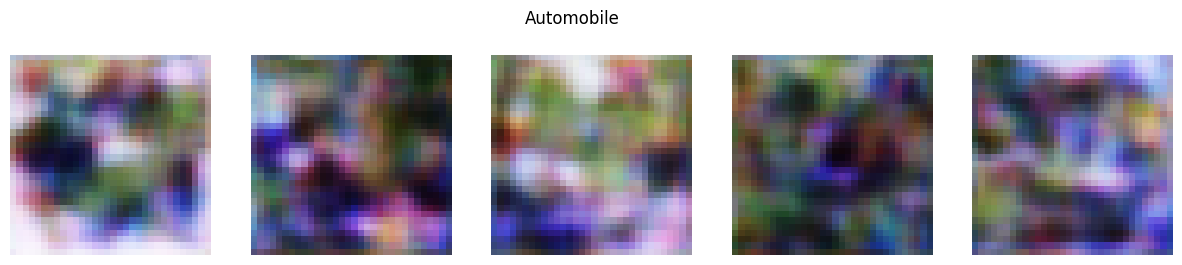

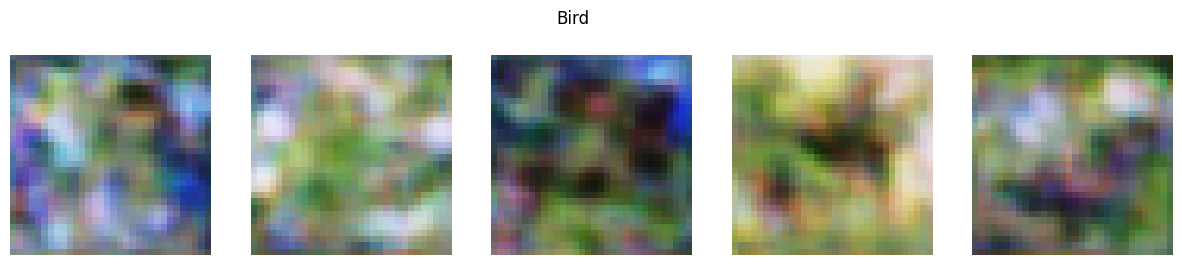

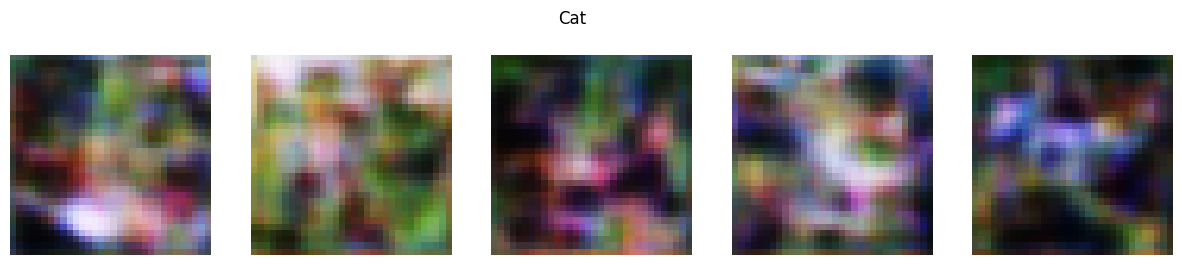

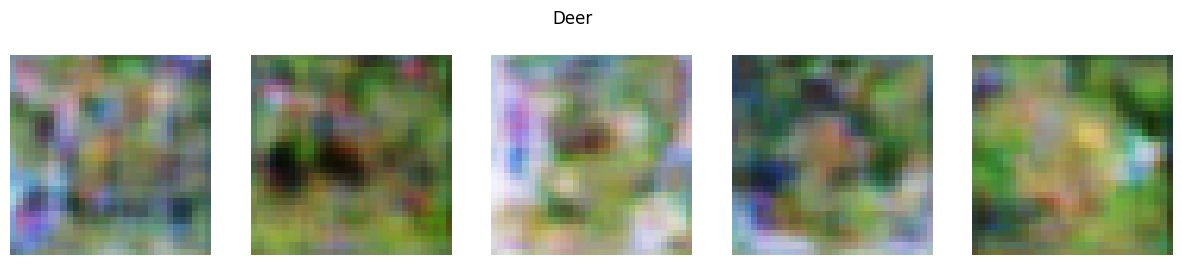

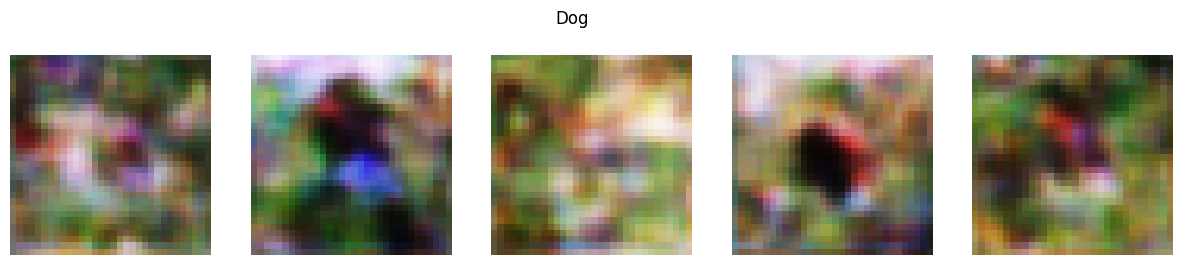

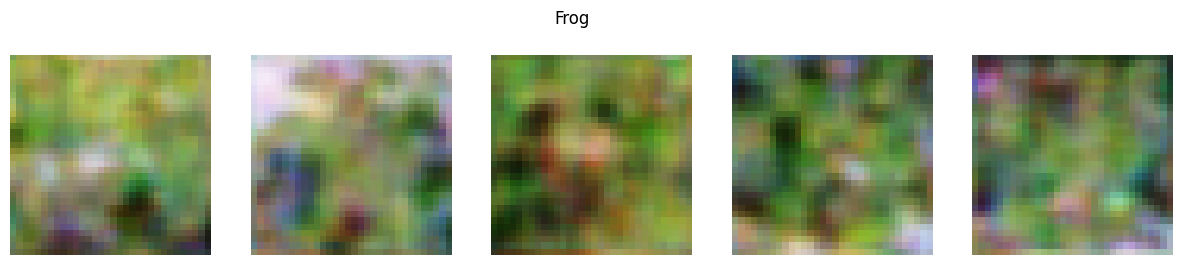

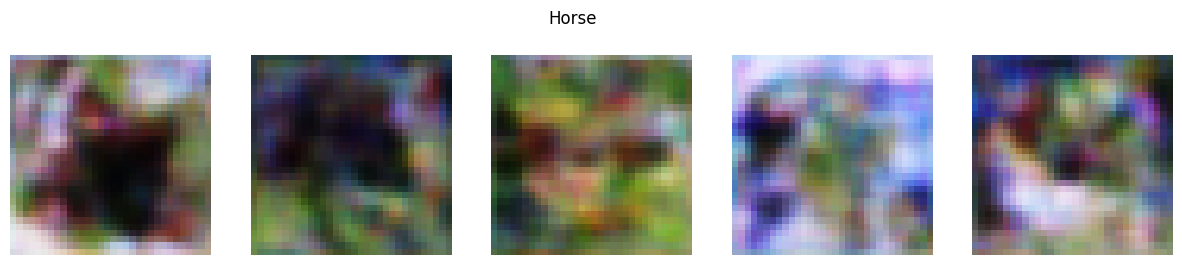

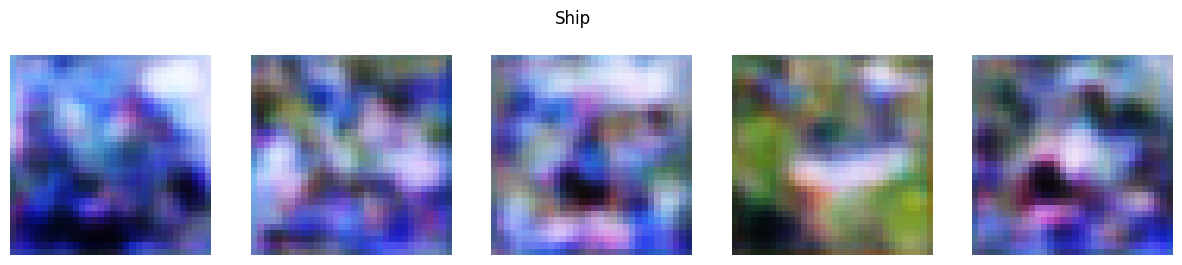

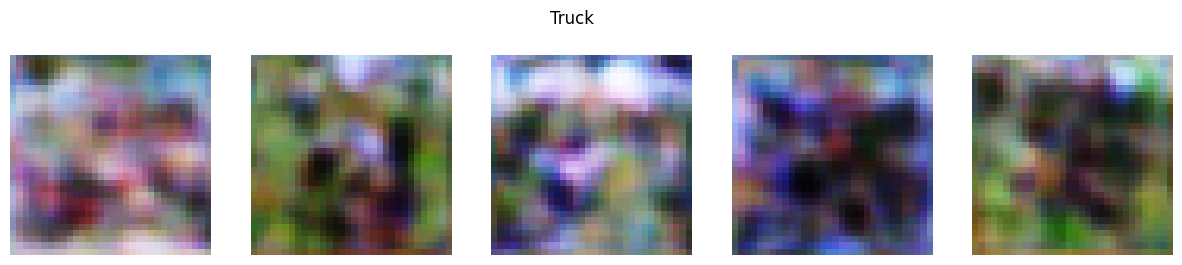

In [39]:
import matplotlib.pyplot as plt
label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Generate and display images
for i in range(10):
    z = torch.randn(5, latent_dim).cuda()
    labels = torch.full((5,), i, dtype=torch.long).cuda()  # Generate 5 images for class 'i'
    gen_imgs = generator(z, labels)

    # Convert images for display
    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]
    gen_imgs = gen_imgs.detach().cpu()

    # Display images
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(label_names[i])

    for j in range(5):
        axs[j].imshow(gen_imgs[j].permute(1, 2, 0))
        axs[j].axis('off')

    plt.show()